# Introduction And Problem Statement

In [4]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Author: Alexandre Menai (amenai@amenai.net)

The purpose of this notebook is to serve as a python machine learning guide for me 
or others wishing to have some fun (most important) and understand the limitations
and quirks of different AI algorithms.
I am writing this as I am reading the excellent book by Raschka, Sebastian and Vahid Mirjalili:
Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition.

I will be using a slightly different set of examples taken from the aviation world
based on multiple factors experienced pilots and regulation impose certain conditions of flights. This lab is an attempt to make decisions based on several physical parameters to fly 
under instrument conditions (IFR) or visual conditions (VFR)
for the sake of discussion we are considering the following parameters: ceiling (cloud altitudes) and visibility
we will assume that the binary decision is possible through those parameters that mimic pilot appreciation. 
<B>CAUTION: PLEASE DO NOT USE THIS FOR FLIGHT DECISION MAKING AND REFER TO YOUR REGULARATORY TEXTS THIS IS JUST AN ILLUSTRATIVE EXAMPLE TO MAKE THE LEARNING PROCESS EASIER!!!</B>



In [5]:
#generate random training data for convenience and save to csv
#initiate a random state for reproductibility of results
rgen=np.random.RandomState(0)
#generate non linearly separable sets
altitudes1 = np.array(rgen.uniform(0, 2000, 500))
visibilities1 = np.array(rgen.uniform(0,3, 500))
altitudes2=np.array(rgen.uniform(2000,2200,500))
visibilities2 = np.array(rgen.uniform(3,6,500))
#concatenate into the same set
altitudes=np.concatenate((altitudes1,altitudes2))
visibilities = np.concatenate((visibilities1, visibilities2))
#randomize the sets further
np.random.shuffle(altitudes)
np.random.shuffle(visibilities)
##########################################
#to proceed with a non linearly separable set
#if alt is less than 2000 feet and visi < 3 then IFR otherwise vfr
flightrules = np.array(np.where((altitudes < 2000) & (visibilities < 3), 'ifr', 'vfr'))
pd.DataFrame({'alt': altitudes, 'visi':visibilities,'cond': flightrules}).to_csv('training_set_nonseperable.csv',index=False)
##########################################

##########################################
#to proceed with a linearly separable set
#only consider visibility as the determining factor
flightrules = np.array(np.where((visibilities < 3), 'ifr', 'vfr'))
pd.DataFrame({'alt': altitudes, 'visi':visibilities,'cond': flightrules}).to_csv('training_set.csv',index=False)

Now that we generated the training sets let's take a look at the linrarly sepaparable one more closely

In [6]:
df = pd.read_csv('training_set.csv')
df.tail(10)

,alt,visi,cond
990,2061.705592,5.424148,vfr
991,1184.083863,1.036517,ifr
992,2055.597989,2.668344,ifr
993,1924.377090,1.868682,ifr
994,2058.277764,3.558390,vfr
995,898.583297,2.235699,ifr
996,2003.412097,1.554449,ifr
997,2159.737850,0.751195,ifr
998,1227.931912,5.525447,vfr
999,907.085365,4.674850,vfr


If we were to consider that IFR conditions need to meet both visibility and ceiling criteria
then our problem of classification our phenomenon is NOT linearly separable:

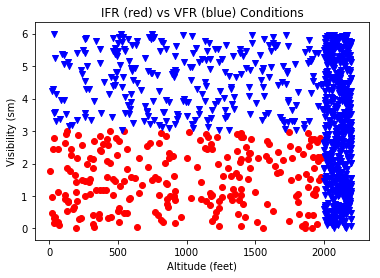

In [7]:
#Load it as a numpy array
trainingset=np.array(df)
#np.random.shuffle(trainingset)
# input
conditions = np.array(df)[:,[0,1]]
# output
decision = np.array(df)[:,2]

IFR=conditions[(conditions[:,0]<2000) & (conditions[:,1]<3)]
VFR=conditions[(conditions[:,0]>2000) | (conditions[:,1]>3)]
plt.scatter(IFR[:,0],IFR[:,1],color='red',marker='o')
plt.scatter(VFR[:, 0], VFR[:, 1], color='blue',marker='v')
plt.xlabel('Altitude (feet)')
plt.ylabel('Visibility (sm)')
plt.title('IFR (red) vs VFR (blue) Conditions')
plt.show()

If we were to consider that IFR conditions need to meet ONLY the visibility criteria
then our problem of classification our phenomenon IS linearly separable:

Text(0.5, 1.0, 'IFR (red) vs VFR (blue) Conditions')

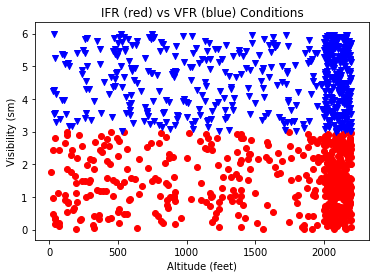

In [8]:

IFR = conditions[(conditions[:, 1] < 3)]
VFR=conditions[(conditions[:,1]>3)]
plt.scatter(IFR[:,0],IFR[:,1],color='red',marker='o')
plt.scatter(VFR[:, 0], VFR[:, 1], color='blue',marker='v')
plt.xlabel('Altitude (feet)')
plt.ylabel('Visibility (sm)')
plt.title('IFR (red) vs VFR (blue) Conditions')

# Teaching The Computer How to Make Decisions

For the rest of this Kab we will be playing with diferent algorithms to solve our decision making problem of IFR vs VFR. We have on purpose made the problem linearly separable to apply the most simplistic algorithms first.

## Splitting our data sample in to a Training Set and a Testing Set

For computing convenience let's first change the decision array from 'vfr','ifr' to +1,-1 respectively.

In [9]:
binary_decision = np.where(decision == 'vfr', 1, -1)

In [10]:
from sklearn.model_selection import train_test_split
conditions_train, conditions_test, binary_decision_train, binary_decision_test = train_test_split(
    conditions, binary_decision, test_size=0.3, random_state=1, stratify=binary_decision)

Verify that the training set and the test set have the same distribution

In [11]:
#np.bincount does not qccpt negative ints so we replaced -1 by 0
print('Labels counts in binary_decision:', np.bincount(np.where(binary_decision==-1,0,1)))
print('Labels counts in binary_decision_train:', np.bincount(np.where(binary_decision_train==-1,0,1)))
print('Labels counts in binary_decision_test:', np.bincount(np.where(binary_decision_test==-1,0,1)))

Labels counts in binary_decision: [500 500]
Labels counts in binary_decision_train: [350 350]
Labels counts in binary_decision_test: [150 150]


Standardizing the features to numbers between 0 and 1 seems to be more convenient and helps most algorithms deal with smaller numbers so the execute and converge faster.

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(conditions_train)
#what this does is normalize every feature value to its mean and standard deviation 
#this is equivalent to the the following operations:
#conditions_std=np.copy(conditions)
#conditions_std[:,0]=(conditions[:,0]-conditions[:,0].mean())/conditions[:,0].std()
#conditions_std[:,1] = (conditions[:, 1] - conditions[:, 1].mean()) / conditions[:, 1].std()
conditions_train_std = sc.transform(conditions_train)
conditions_test_std = sc.transform(conditions_test)
#verify before / after
print(conditions_test[0][0])
print(conditions_test_std[0][0])

2091.6424519517223
0.7946595209561068


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Teaching a Perceptron

In [13]:
#a good utility for plotting decision regions taken from:
#https://github.com/rasbt/python-machine-learning-book-2nd-edition
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

for a <a href="https://en.wikipedia.org/wiki/Perceptron">refresher on perceptrons</a>
<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/Perceptron_files/perceptron_schematic.png" width ="300" />

### Linearily Seprable Case

In [14]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
#initialize a perceptron
ppn = Perceptron(max_iter=1000, eta0=0.01, random_state=100,fit_intercept=True)
#train it
ppn.fit(conditions_train_std, binary_decision_train)
#test it
binary_decision_pred = ppn.predict(conditions_test_std)
print('Misclassified samples: %d' % (binary_decision_test != binary_decision_pred).sum())
print('Accuracy: %.2f' % accuracy_score(binary_decision_test, binary_decision_pred))
print('Accuracy: %.2f' % ppn.score(conditions_test_std, binary_decision_test))
print(ppn.coef_)

Misclassified samples: 0
Accuracy: 1.00
Accuracy: 1.00
[[0.00415659 0.42563071]]


Hmmm, looks pretty accurate Let's look at how the learning went progressively and set fit_intercept=False in order not to make it easy on the perceptron (be patient)

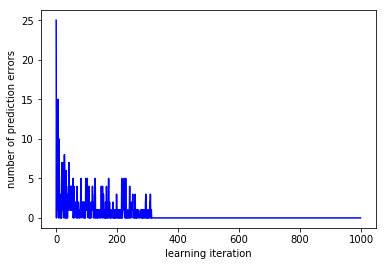

[[0.00415659 0.42563071]]


In [15]:
errors=[]
for _ in range(1,1000):
    ppn = Perceptron(max_iter=_, eta0=0.01, random_state=100,fit_intercept=True,shuffle=True)
    #train it
    ppn.fit(conditions_train_std, binary_decision_train)
    #test it
    binary_decision_pred = ppn.predict(conditions_test_std)
    errors.append((binary_decision_test != binary_decision_pred).sum())

plt.plot(range(len(errors)),errors,color='blue',marker='')
plt.xlabel('learning iteration')
plt.ylabel('number of prediction errors')
plt.show()
print(ppn.coef_)

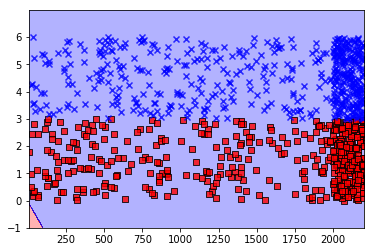

In [16]:
plot_decision_regions(conditions,decision,ppn)

### Non Linearily Separable

In [17]:
df = pd.read_csv('training_set_nonseperable.csv')
df.tail()

,alt,visi,cond
995,898.583297,2.235699,ifr
996,2003.412097,1.554449,vfr
997,2159.737850,0.751195,vfr
998,1227.931912,5.525447,vfr
999,907.085365,4.674850,vfr


In [18]:
#Load it as a numpy array
trainingset=np.array(df)
#np.random.shuffle(trainingset)
# input
conditions = np.array(df)[:,[0,1]]
# output
decision = np.array(df)[:,2]

#preprocessing

binary_decision = np.where(decision == 'vfr', 1, -1)
from sklearn.model_selection import train_test_split
conditions_train, conditions_test, binary_decision_train, binary_decision_test = train_test_split(
    conditions, binary_decision, test_size=0.3, random_state=1, stratify=binary_decision)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(conditions_train)
#what this does is normalize every feature value to its mean and standard deviation 
#this is equivalent to the the following operations:
#conditions_std=np.copy(conditions)
#conditions_std[:,0]=(conditions[:,0]-conditions[:,0].mean())/conditions[:,0].std()
#conditions_std[:,1] = (conditions[:, 1] - conditions[:, 1].mean()) / conditions[:, 1].std()
conditions_train_std = sc.transform(conditions_train)
conditions_test_std = sc.transform(conditions_test)
#verify before / after
print(conditions_test[0][0])
print(conditions_test_std[0][0])

#Learning
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
#initialize a perceptron
ppn = Perceptron(max_iter=1000, eta0=0.01, random_state=100,fit_intercept=True)
#train it
ppn.fit(conditions_train_std, binary_decision_train)
#test it
binary_decision_pred = ppn.predict(conditions_test_std)
print('Misclassified samples: %d' % (binary_decision_test != binary_decision_pred).sum())
print('Accuracy: %.2f' % accuracy_score(binary_decision_test, binary_decision_pred))
print('Accuracy: %.2f' % ppn.score(conditions_test_std, binary_decision_test))
print(ppn.coef_)

2052.5599912648972
0.739317929194579
Misclassified samples: 43
Accuracy: 0.86
Accuracy: 0.86
[[0.02049785 0.01068669]]


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


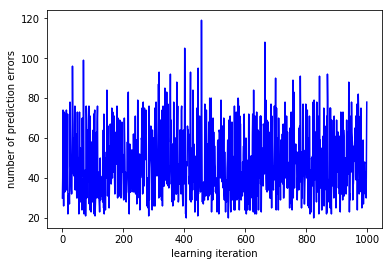

[[0.01768004 0.02478307]]


In [19]:
errors=[]
for _ in range(1,1000):
    ppn = Perceptron(max_iter=_, eta0=0.01, random_state=100,fit_intercept=True,shuffle=True)
    #train it
    ppn.fit(conditions_train_std, binary_decision_train)
    #test it
    binary_decision_pred = ppn.predict(conditions_test_std)
    errors.append((binary_decision_test != binary_decision_pred).sum())

plt.plot(range(len(errors)),errors,color='blue',marker='')
plt.xlabel('learning iteration')
plt.ylabel('number of prediction errors')
plt.show()
print(ppn.coef_)

Not as easy :)

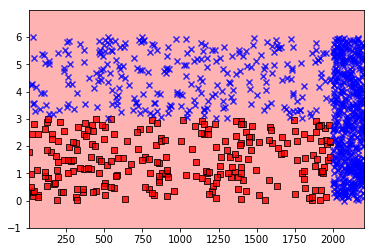

In [20]:
plot_decision_regions(conditions,decision,ppn)

# Using a Logistic Regression

The logistic regression is NOT a linear regression it is a classification function that allows in some cases faster convergence of a perceptron that is learning a linearly separable set. The reason the logistic regression performs better than a regular perceptron is because it deals better with outliers. It actually detects if an outlier is an outlier and minimizes the effect of it by classifying it as close as possible to the dominant group. 

it does this by using a mathematical function called the sigmoid:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9537e778e229470d85a68ee0b099c08298a1a3f6" />
<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" />

As the perceptron learns this function allows to measure the probability that a specific sample belongs to a specific class by associating it to the "net product"

<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/LogisticRegression_files/logistic_regression_schematic.png" />

This will seem a bit socratic in a few years to me. Since I am a practical man I am going to use a practical example:
let's say we have in our sample a few visibilities and cielings a few that are not in "range":

In [21]:
altitudes3 = np.array(rgen.uniform(3000, 3100, 50))
visibilities3 = np.array(rgen.uniform(0, 0.5, 50))
altitudes=np.concatenate((altitudes,altitudes3))
visibilities=np.concatenate((visibilities,visibilities3))                        
np.random.shuffle(altitudes)
np.random.shuffle(visibilities)
##########################################
#to proceed with a linearly separable set
#if visi < 3 then IFR otherwise vfr
flightrules = np.array(np.where(altitudes < 2000, 'ifr', 'vfr'))
pd.DataFrame({'alt': altitudes, 'visi':visibilities,'cond': flightrules}).to_csv('training_set_seperable_withoutliers.csv',index=False)
##########################################

Now let's plot thoses

Text(0.5, 1.0, 'IFR (red) vs VFR (blue) Conditions')

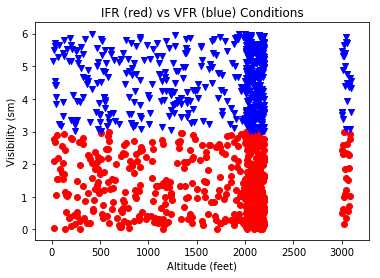

In [22]:
dfO = pd.read_csv('training_set_seperable_withoutliers.csv')
trainingset=np.array(dfO)
#np.random.shuffle(trainingset)
# input
conditions = np.array(dfO)[:,[0,1]]
# output
decision = np.array(dfO)[:,2]
IFR = conditions[(conditions[:, 1] < 3)]
VFR=conditions[(conditions[:,1]>3)]
plt.scatter(IFR[:,0],IFR[:,1],color='red',marker='o')
plt.scatter(VFR[:, 0], VFR[:, 1], color='blue',marker='v')
plt.xlabel('Altitude (feet)')
plt.ylabel('Visibility (sm)')
plt.title('IFR (red) vs VFR (blue) Conditions')

Let's run the same perceptron to see how many iterations it converges in the new set


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2075.9787807572034
0.6105339722960853
Misclassified samples: 4
Accuracy: 0.99
Accuracy: 0.99
[[0.10417501 0.00153472]]


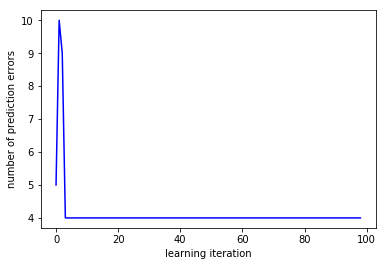

[[0.10417501 0.00153472]]


In [23]:
binary_decision = np.where(decision == 'vfr', 1, -1)
from sklearn.model_selection import train_test_split
conditions_train, conditions_test, binary_decision_train, binary_decision_test = train_test_split(
    conditions, binary_decision, test_size=0.3, random_state=1, stratify=binary_decision)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(conditions_train)
#what this does is normalize every feature value to its mean and standard deviation 
#this is equivalent to the the following operations:
#conditions_std=np.copy(conditions)
#conditions_std[:,0]=(conditions[:,0]-conditions[:,0].mean())/conditions[:,0].std()
#conditions_std[:,1] = (conditions[:, 1] - conditions[:, 1].mean()) / conditions[:, 1].std()
conditions_train_std = sc.transform(conditions_train)
conditions_test_std = sc.transform(conditions_test)
#verify before / after
print(conditions_test[0][0])
print(conditions_test_std[0][0])

#Learning
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
#initialize a perceptron
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=100,fit_intercept=True)
#train it
ppn.fit(conditions_train_std, binary_decision_train)
#test it
binary_decision_pred = ppn.predict(conditions_test_std)
print('Misclassified samples: %d' % (binary_decision_test != binary_decision_pred).sum())
print('Accuracy: %.2f' % accuracy_score(binary_decision_test, binary_decision_pred))
print('Accuracy: %.2f' % ppn.score(conditions_test_std, binary_decision_test))
print(ppn.coef_)

errors=[]
for _ in range(1,100):
    ppn = Perceptron(max_iter=_, eta0=0.01, random_state=100,fit_intercept=True,shuffle=True)
    #train it
    ppn.fit(conditions_train_std, binary_decision_train)
    #test it
    binary_decision_pred = ppn.predict(conditions_test_std)
    errors.append((binary_decision_test != binary_decision_pred).sum())

plt.plot(range(len(errors)),errors,color='blue',marker='')
plt.xlabel('learning iteration')
plt.ylabel('number of prediction errors')
plt.show()
print(ppn.coef_)

so it took our perceptron a little more than 20 iterations to get it almost right
Now let's try with a logistic regression.

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

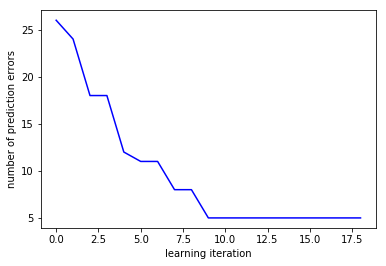

In [24]:
from sklearn.linear_model import LogisticRegression


errors=[]
for _ in range(1,20):
    lr = LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=_, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
    #train it
    lr.fit(conditions_train_std, binary_decision_train)
    #test it
    binary_decision_pred = lr.predict(conditions_test_std)
    errors.append((binary_decision_test != binary_decision_pred).sum())

plt.plot(range(len(errors)),errors,color='blue',marker='')
plt.xlabel('learning iteration')
plt.ylabel('number of prediction errors')
plt.show()


It looks like for the same sample the lodistic regression converges much faster. now the book I am reading has some interesting functions about the fact that we can calculate the probabilities associated with each sample:

In [25]:
print(conditions_test_std[:3,])
print(binary_decision_test[:3,])
lr.predict_proba(conditions_test_std[:3,])

[[ 0.61053397  1.02868249]
 [ 0.56196579  1.13522389]
 [-0.2016926   0.74328959]]
[ 1  1 -1]


array([[1.58423201e-03, 9.98415768e-01],
       [1.14779158e-02, 9.88522084e-01],
       [1.00000000e+00, 1.39967585e-12]])

the probabilities correspond to the likelyhood a sample belongs to the first (IFR) or second (VFR) class of prediction. the numbers speak for them selves. and all probabilities should add up to 1

In [26]:
lr.predict_proba(conditions_test_std).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# The Overfitting / Underfitting Disease

According to Raschka, Sebastian. Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition (p. 73). Packt Publishing. Édition du Kindle. :
<i>"Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters that lead to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance on unseen data."</i>



Let's get back to our sample problem to descripe the different problems of overfitting underfitting disease

## Overfitting Problem Description

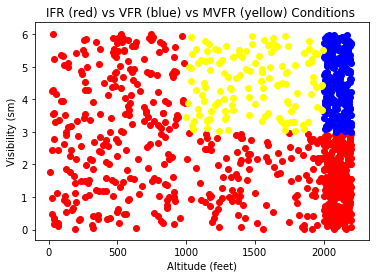

In [27]:
trainingset=np.array(pd.read_csv('training_set_nonseperable.csv'))
# input
conditions = np.array(trainingset)[:,[0,1]]
# output
IFR=conditions[(conditions[:, 1] < 3) | (conditions[:,0] < 1000 )]
VFR=conditions[(conditions[:,1]>=3) & (conditions[:,0]>=2000) ]
MVFR=conditions[(conditions[:,1]>=3)& (conditions[:,0] <2000) & (conditions [:,0] >=1000)]

plt.scatter(IFR[:,0],IFR[:,1],color='red')
plt.scatter(VFR[:, 0], VFR[:, 1], color='blue')
plt.scatter(MVFR[:, 0], MVFR[:, 1], color='yellow')
plt.xlabel('Altitude (feet)')
plt.ylabel('Visibility (sm)')
plt.title('IFR (red) vs VFR (blue) vs MVFR (yellow) Conditions ')
plt.show()

Let's create a 3 outcome decision set

In [28]:
d=[]
for x in conditions[:,]:
    #print(x)
    if x in IFR:
        #print("IFR")
        d.append(-1)
    elif x in MVFR:
        #print("MVFR")
        d.append(0)
    else:
        #print["VFR"]
        d.append(1)
decision=np.array(d)
#print(decision)
conditions.shape[0]==decision.shape[0]

True

Now let's splt into training and test sets

In [29]:
conditions_train, conditions_test, decision_train, decision_test = train_test_split(
    conditions, decision, test_size=0.3, random_state=1, stratify=decision)

Let's train a logistic regression

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


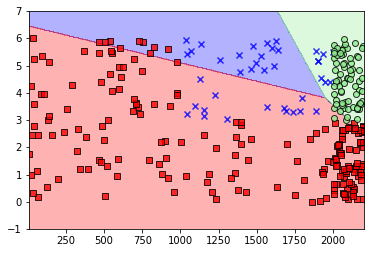

In [30]:

lr = LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
        intercept_scaling=1, max_iter=100, multi_class='warn',
        n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
        tol=0.0001, verbose=0, warm_start=False)
#train it
lr.fit(conditions_train,decision_train)

plot_decision_regions(conditions_test,decision_test, lr)


The decision regions above show a high bias problem for the "Marginal VFR" conditions (due to non seperability). But they are quite acceptable for the IFR and VFR conditions.
now let's try with a regular perceptron.

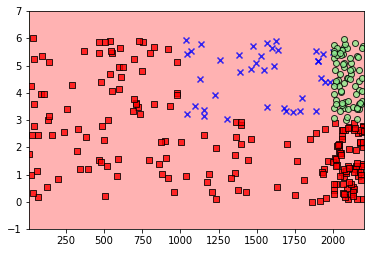

In [31]:
ppn = Perceptron(tol=1e-3, random_state=0)
ppn.fit(conditions_train,decision_train)
plot_decision_regions(conditions_test,decision_test, ppn)

The above is an "Huge" illustration of High bias . most of the samples are IFR and the decsion region is biased towards IFR and will never detect the VFR samples correctly.

Finally let's try with an Stochastic Gradient Descent perceptron. (a perceptron that adjusts the learning rate dynamically as it iterates throught the training set. Like a basketball descending to a hole:
<img src="https://cdn-images-1.medium.com/max/1600/1*_6nUFOhjPv3ftr8CrrWANQ.png"/>


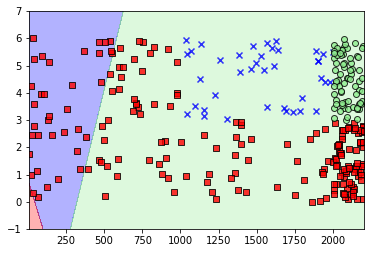

In [32]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(alpha=0.001, max_iter=100)
sgd.fit(conditions_train,decision_train)
plot_decision_regions(conditions_test,decision_test, sgd)

This is a little better than perceptron but still far inferior to the logistic regression.

now peaking at this site : https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html

it looks like we could be better off with a nearest neighbour classifier:

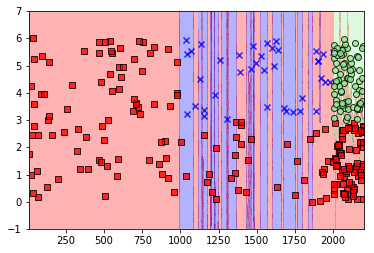

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(conditions_train,decision_train)
plot_decision_regions(conditions_test,decision_test, knn)

Maybe the detailed explanation is for another day but this may be a good example of overfitting. we'll learn more soon.

## How to treat Overfitting

Depending on the algorithm, treating overfitting can be achieved in multiple ways. The general idea is that we should prefer a status of the learning machine that is likeley to be more general (so less specific) to the training sample. one technique that is describe in what is now one of my favorite books is called "regularization". Regularisation penalizes extreme values of weights by making the overall weights smaller. it is linked to the C parameter of the logistic regression. The smaller the parameter the smaller the better we control the outlier weights.
<br/>
Bottom line:
<br/>
small C => Strong regularisation
<br/>
big C => shallow Regularization
<br/>
Now I am tempted to try multiple regularisation parameters to see how things evolve

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


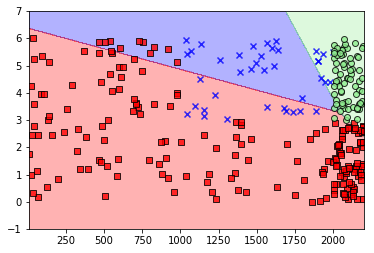

In [44]:
lr={}
for _ in range(1,500,10):
    lr[_] = LogisticRegression(C=_, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='auto',
            n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
            tol=0.0001, verbose=0, warm_start=False)
    #train it
    lr[_].fit(conditions_train,decision_train)

plot_decision_regions(conditions_test,decision_test, lr[1])




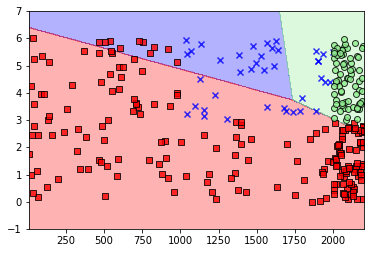

In [41]:
plot_decision_regions(conditions_test,decision_test, lr[21])

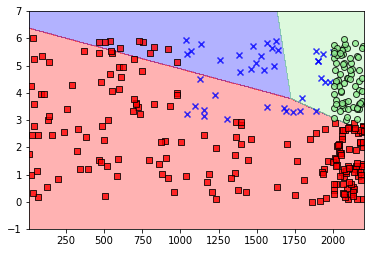

In [42]:
plot_decision_regions(conditions_test,decision_test, lr[51])

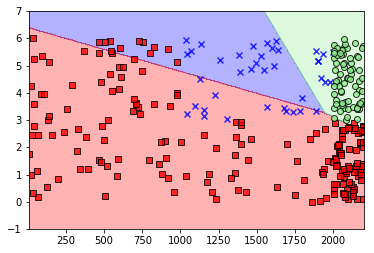

In [43]:
plot_decision_regions(conditions_test,decision_test, lr[91])

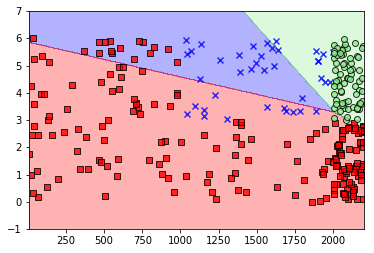

In [45]:
plot_decision_regions(conditions_test,decision_test, lr[181])

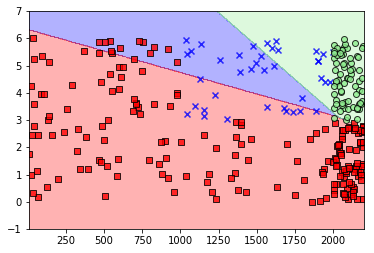

In [46]:
plot_decision_regions(conditions_test,decision_test, lr[421])

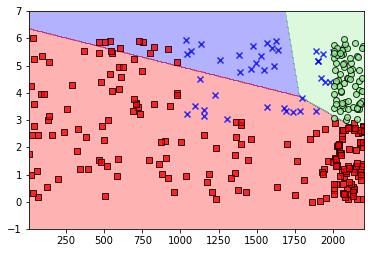

In [47]:
plot_decision_regions(conditions_test,decision_test, lr[491])

In our case it looks like when we increase C shallow reuglarisation the decisions seem to get better  

# (Hire a Surveyor) Support Vector Machine